<a href="https://colab.research.google.com/github/MithunKiniStar/AutoEncoders/blob/main/FaceToSketch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re

In [3]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

image_path = '/content/photos'
img_array = []

sketch_path = '/content/sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))


for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    
    #Image Augmentation
    # horizontal flip 
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))

100%|██████████| 9/9 [00:00<00:00, 79.33it/s]


Slicing and reshaping

In [28]:
train_sketch_image = sketch_array[:50]
train_image = img_array[:50]
test_sketch_image = sketch_array[50:]
test_image = img_array[50:]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Train color image shape: (50, 256, 256, 3)
Test color image shape (22, 256, 256, 3)


In [27]:
len(train_sketch_image)

72

Downsample layer¶

In [29]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


Upsample Layer

In [30]:
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU()) 
    return upsample

In [31]:
def model():
    encoder_input = keras.Input(shape = (SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32,4)(x)
    x = downsample(64,4,False)(x)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)
   
    encoder_output = downsample(512,4)(x)
    
    decoder_input = upsample(512,4,True)(encoder_output)
    x = upsample(256,4,False)(decoder_input)
    x = upsample(128,4, True)(x)
    x = upsample(64,4)(x)
    x = upsample(32,4)(x)
    x = upsample(16,4)(x)
    x = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)
    
  
    return tf.keras.Model(encoder_input, decoder_output)

To get summary of model

In [32]:
model = model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_12 (Sequential)  (None, 127, 127, 16)      768       
                                                                 
 sequential_13 (Sequential)  (None, 62, 62, 32)        8320      
                                                                 
 sequential_14 (Sequential)  (None, 30, 30, 64)        32768     
                                                                 
 sequential_15 (Sequential)  (None, 14, 14, 128)       131584    
                                                                 
 sequential_16 (Sequential)  (None, 6, 6, 256)         525312    
                                                                 
 sequential_17 (Sequential)  (None, 2, 2, 512)         2099

Compiling and Fitting our model

In [33]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_image, train_sketch_image, epochs = 100, verbose = 0)

Evaluating our model

In [34]:

prediction_on_test_data = model.evaluate(test_image, test_sketch_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

1/1 [==============================] - 1s 1s/step - loss: 0.1651 - acc: 0.4239
Loss:  0.16505089402198792
Accuracy:  42.4


In [15]:
test_image = test_image.astype(int)
test_image1

array([], shape=(0, 256, 256, 3), dtype=int64)

Plotting our predicted sketch along with real sketch

In [35]:
def show_images(real,sketch, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Image",fontsize = 15, color = 'Lime')
    plt.imshow(real)
    plt.subplot(1,3,2)
    plt.title("sketch",fontsize = 15, color = 'Blue')
    plt.imshow(sketch)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)


Streaming output truncated to the last 5000 lines.
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]


 [[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


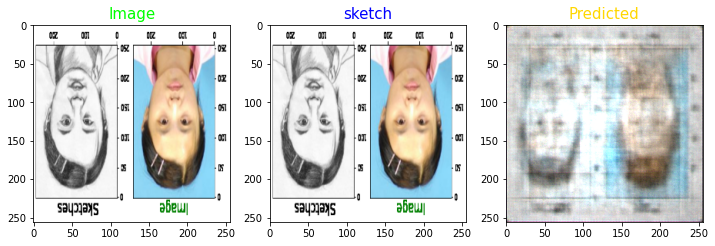

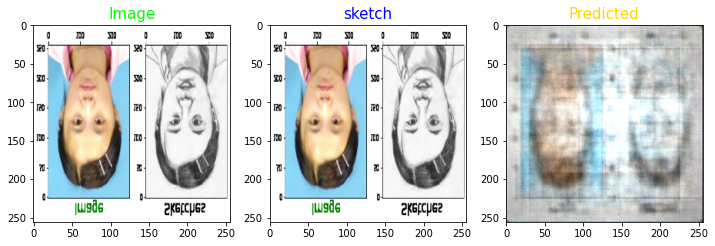

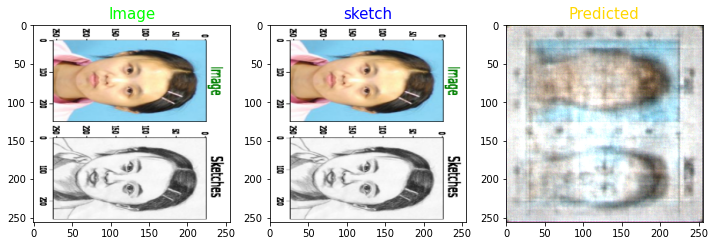

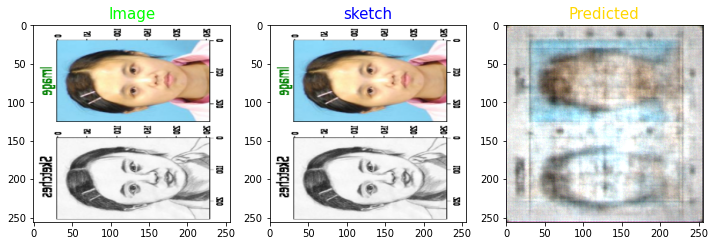

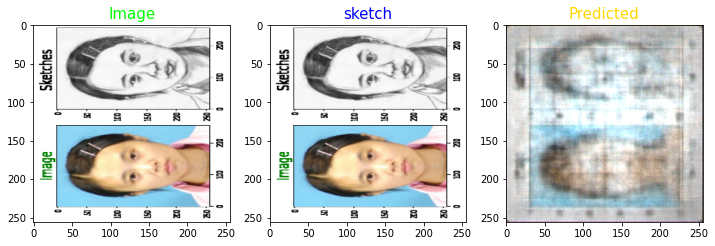

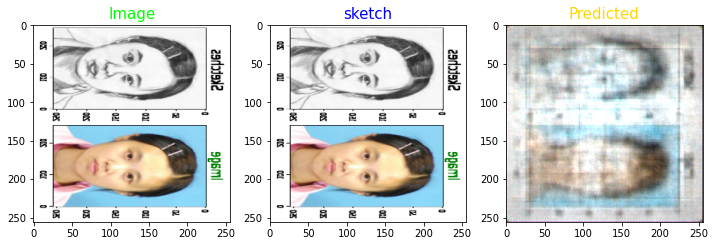

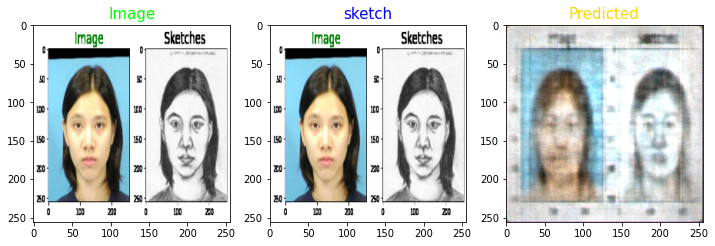

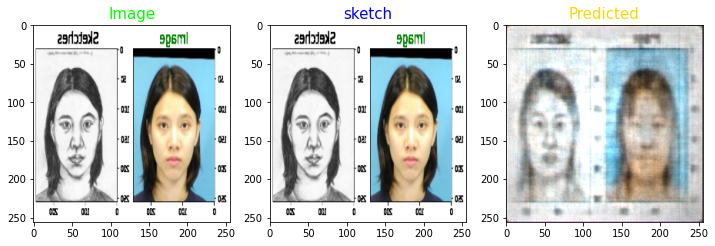

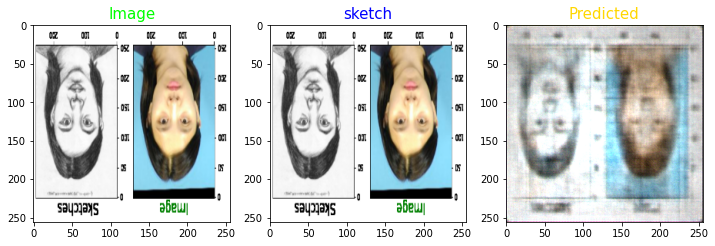

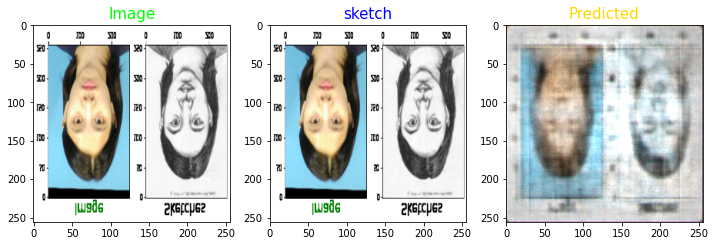

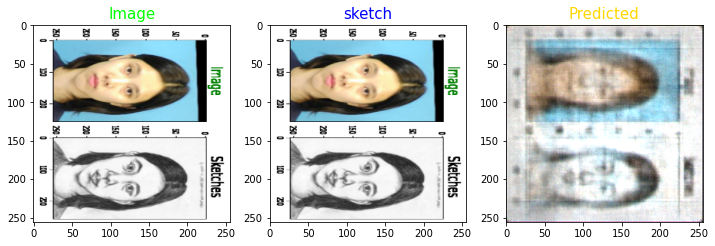

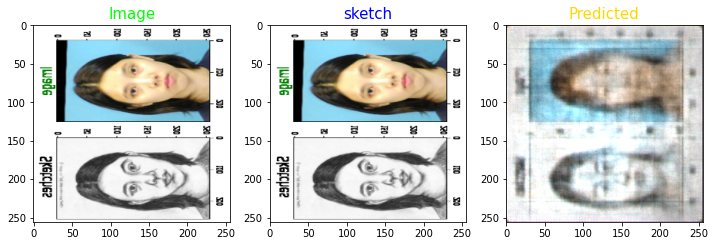

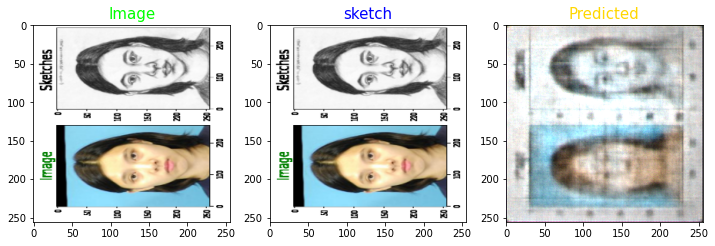

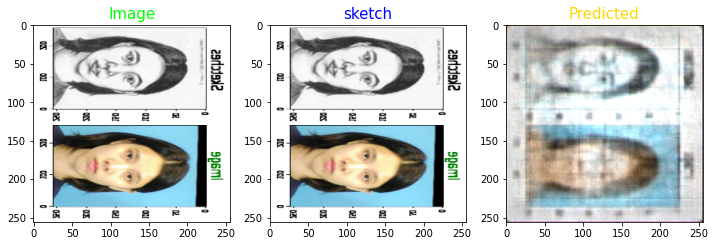

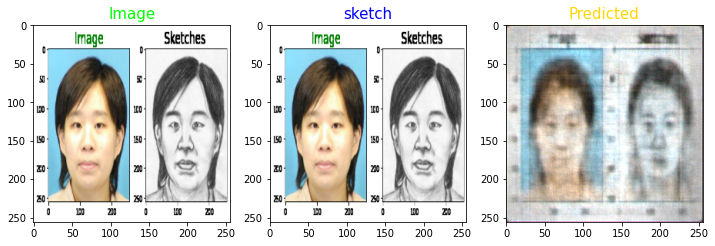

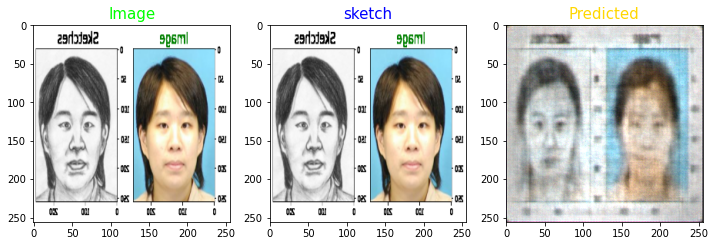

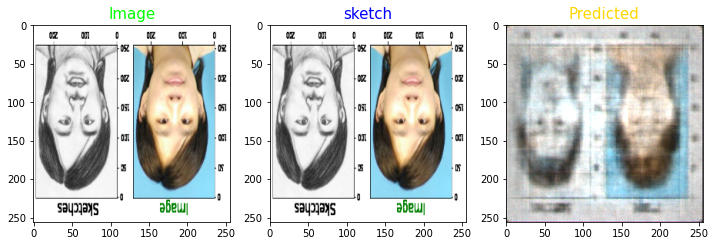

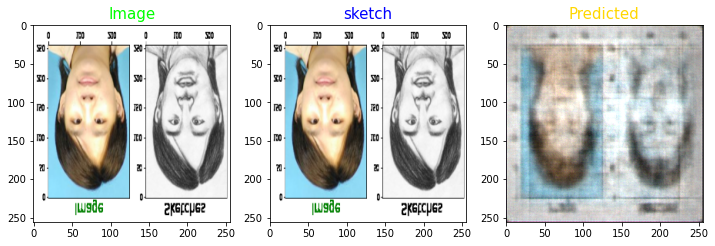

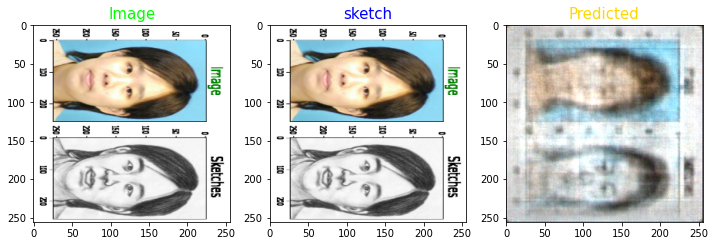

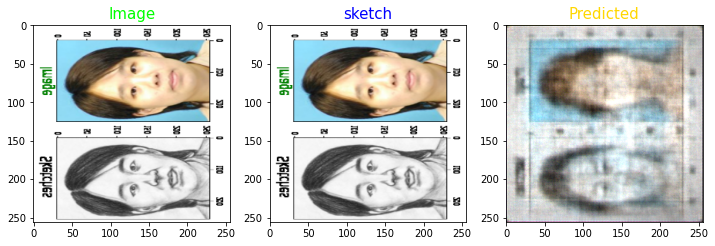

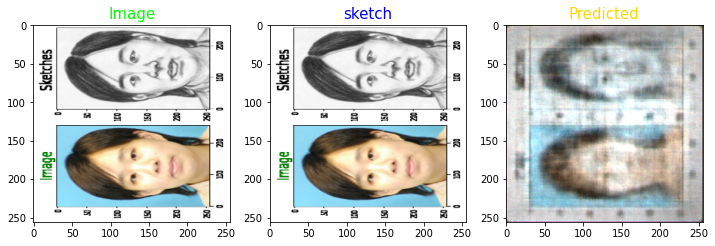

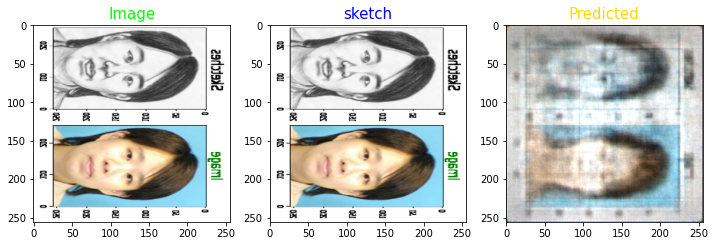

In [38]:
ls = [i for i in range(0,22)]
for i in ls:
    print(test_image)
    model.predict(test_image[i].reshape(1,SIZE,SIZE,3))
    predicted =np.clip(model.predict(test_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_image[i],test_sketch_image[i],predicted)